# MLP

This is an MLP model that explores using a single vector derived from pre-trained word embedding vectors.


Step 1: Importing the required libraries

In [45]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

Step 2: Loading the pre-trained glove vector embedding model 

In [46]:
# Load pre-trained embedding layer
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False) # for now binary is true

Step 3: Load training and testing data

In [71]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
training_data = df_training.values[:,0]
training_labels = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
testing_data = np.array(df_testing.values[:,0])
testing_labels = np.array(df_testing.values[:,1], dtype=np.float32)

(2000,)


Step 4: Pre-Processing training and testing data:

This phase creates a new csv file with pre-processed data that can be used by each of the models it has a few functions including: 

- Remove any punctuation
- make sentences lowercase
- Remove URL's
- Lemize words
- Tokenise the words
- Remove stop words



In [72]:
import re
import numpy as np
import nltk

# Preprocess the text: lowercase, remove special characters, tokenize
def remove_special_characters_and_tokenise(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = []
    for word in nltk.word_tokenize(text):
        tokens.extend(re.findall(r'\b\w+\b', word))  # Split combined words into separate tokens
    return tokens

# Remove stopwords
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    return [word for word in tokens if word not in stopwords]

# Lemmatization
def perform_lemmatization(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Clean the sentence: Apply the cleaning process to a single sentence
def clean_sentence(sentence):
    tokens = remove_special_characters_and_tokenise(sentence)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    return tokens

# Preprocess the data: Apply the cleaning process to all sentences in data
def pre_process_data(data):
    token_arrays = []  
    for sentence in data:
        tokens = clean_sentence(sentence)
        token_arrays.append(np.array(tokens))
    return token_arrays

In [75]:
X_train_tokens = pre_process_data(training_data)
X_test_tokens = pre_process_data(testing_data)

# does not tokenize names and countries properly yet need to add additional pre-processing steps
# print (X_test_tokens[0])
# print (X_train_tokens[0])

['seanmdav' 'breaking' 'trumpliedamericansdied' 'realdonaldtrump' 'knew'
 'covid19' 'airborne' 'chose' 'come' 'forward' 'information'
 'trumpdeathtoll200k']
['cdc' 'currently' 'report' '99031' 'death' 'general' 'discrepancy'
 'death' 'count' 'different' 'source' 'small' 'explicable' 'death' 'toll'
 'stand' 'roughly' '100000' 'people' 'today']


Create token embeddings for each of the pre-processed words using pre-trained word vectors glove

In [76]:
# here I am embedding each of the post-processed sentences into there glove representation
def embed_text_glove(tokens):
    embedded_text = []
    for sentence in tokens:
        embedded_sentence = []
        for word in sentence:
            try:
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                pass
        embedded_text.append(embedded_sentence)
    return embedded_text

In [78]:
X_train_glove_embedded = embed_text_glove(X_train_tokens) 
X_test_glove_embedded = embed_text_glove(X_test_tokens)

print (type(X_train_glove_embedded))

<class 'list'>


Apply padding to the embedded words


In [94]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def embed_text_glove(data, max_length): 

    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')
    return np.array(padded_data)


In [95]:
max_words_per_sentence = max(len(sentence) for sentence in X_train_glove_embedded)
X_train_glove_embedded = embed_text_glove(X_train_glove_embedded, max_words_per_sentence)
X_test_glove_embedded = embed_text_glove(X_test_glove_embedded, max_words_per_sentence)

print (X_train_glove_embedded.shape) # the max setnence length for training is 835 which is a
print (X_test_glove_embedded.shape) # The max sentence length for testing is 47



(2000, 835, 300)
(500, 835, 300)


Create a function which creates the model

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import numpy as np
from keras import regularizers
from keras.optimizers import Adam

# flatten the embeddings vector represenetaiton
flattend_training_data = X_train_glove_embedded.reshape(X_train_glove_embedded.shape[0], -1)

# Define the MLP model
model = Sequential()
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(flattend_training_data.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.025
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
training_labels = np.array(training_labels, dtype=np.float32)

# Train the model
model.fit(flattend_training_data, training_labels, epochs=300, batch_size=100, validation_split=0.2)




c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5646 - loss: 1750.1368 - val_accuracy: 0.7600 - val_loss: 530.5511
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6803 - loss: 581.3984 - val_accuracy: 0.7250 - val_loss: 951.2496
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7149 - loss: 782.1542 - val_accuracy: 0.7525 - val_loss: 550.4658
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6819 - loss: 469.0221 - val_accuracy: 0.7375 - val_loss: 506.7071
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7476 - loss: 516.1470 - val_accuracy: 0.7450 - val_loss: 462.9381
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7210 - loss: 405.6280 - val_accuracy: 0.7375 - val_loss: 384.9035
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7347 - loss: 429.4532 - val_accuracy: 0.7250 - val_loss: 595.2640
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7304 - loss: 497.4135 - val_acc

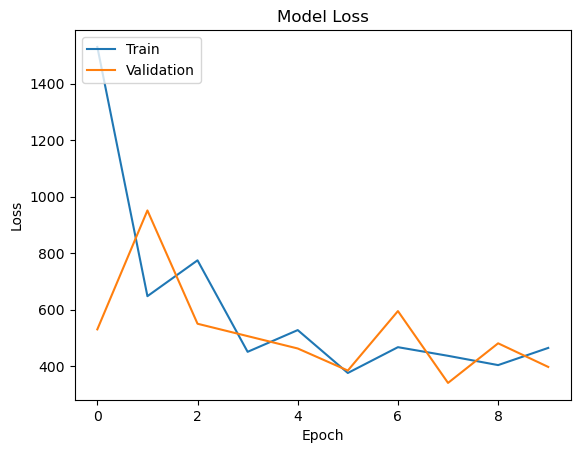

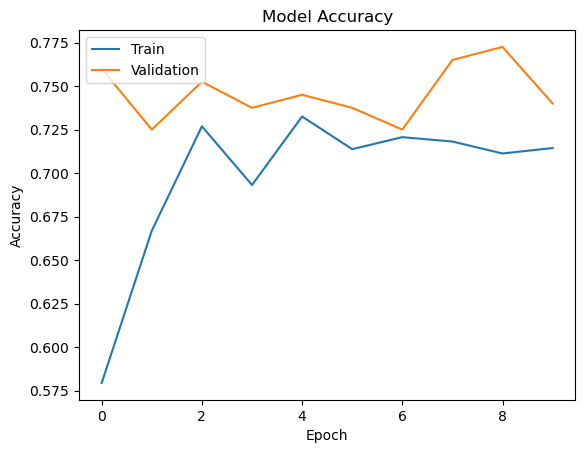

In [97]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


loss = model.evaluate(, y_training)
print("Loss:", loss)


In [103]:
X_test_glove_embedded = X_test_glove_embedded.reshape(X_test_glove_embedded.shape[0], -1)
print (X_test_glove_embedded.shape)
print (testing_labels.shape)
testing_labels = np.array(testing_labels, dtype=np.float32)
loss, accuracy = model.evaluate(X_test_glove_embedded, testing_labels)
print("Loss:", loss)

(500, 250500)
(500,)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7507 - loss: 397.6945
Loss: 397.6869812011719


Using test data to see model performance: This validation and training perfromacne proves that there is overfitting in the model. It seems after experimenation that a standard MLP is not fit for the task of determining false information or true information. I tried changing model hyper parameters such as batch size, and learning rate as well as changing model archetecture as I believe that the model was not performing well due to being to complex but perhaps I was wrong.

Now I will try the model using the keras embedding layer instead of just flattening the text embeddings. 

In [135]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer


# Convert text data to sequences of word indices

tokenizer = Tokenizer()

tokenizer.fit_on_texts(training_data)

word_indices = tokenizer.fit_on_texts(training_data)
word_indices = tokenizer.texts_to_sequences(training_data)

# Pad sequences to ensure uniform length
max_sequence_length = 100  # Adjust as needed
padded_sequences = pad_sequences(word_indices, maxlen=max_sequence_length)

# Define the MLP model
model = Sequential()
model.add(Embedding(input_dim=len(word_indices), output_dim=word, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer='l1'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer='l1'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
learning_rate = 0.05
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Convert training labels to numpy array
training_labels = np.array(training_labels, dtype=np.float32)

# Train the model
model.fit(padded_sequences, training_labels, epochs=100, batch_size=200, validation_split=0.2)

[69, 189, 223, 3470, 7, 213, 3471, 59, 855, 326, 1033, 432, 3472, 59, 541, 462, 1631, 1272, 5, 20]
